# Generative Adverserial Imitation Learning

Generative Adversarial Imitation Learning (GAIL) was first proposed in the paper [Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476) by Jonathan Ho and Stefano Ermon. The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

GAIL is based on the setting of Reinforcement Learning (RL). In Reinforcment Learning, the agent interacts with the environment through its actions and receives rewards in return. The aim of the learning process is to maximize to cummulative reward by chosing the right action in the states.

As the name suggests, GAIL falls into a smaller subgroup of RL, called Imitation Learning. In this setup the goal of the agent is to mimik an expert behavior as closely as possible. The environment awards higher rewards to expert-like behavior and smaller to actions which deviate from the expert behavior much. In our case, expert trajectories were generated from real life data, namely from the interaction dataset, as well as from a pretrained SAC (Soft Actor-Critic) agent. The expert trajectories, which are gained in this way represent the expert knowladge by containing many states and the corresponding actions which were produced by the expert.

A said, the learning of the agent in the RL setting is driven by the rewards it receives from the environmen. The amount of the reward in the Imitation Learning case are determined based on how closely the agent mimics the expert behavior. Furthermore, specially in the GAIL approach we get the reward from an adversarial game: The agent is represented by the generator network, which is trained based on the feedback of the discriminator network. The generator produces actions for given states, which are then judged by the discriminator. In the meantime the discriminator is trained by feeding it expert and agent state-action pairs for classification. In this way the generator tries to fool the discriminator, hence tries to act as expert-like as possible, meanwhile the discriminator tries to identify expert and agent trajectories from eachother. Intuitively the learning converges, when the generator learned to act so similarly to the expert that the discriminator can not tell apart expert and agent trajectories any more. In game theory this point is called the Nash-equilibrium.

In practice, the implementation of a GAIL agent is usually solved in the following way for sample efficiency: The agent interacts with the environment by following its actual policy and hence agent state-action pairs are generated. These points are stored in a replay buffer for further learning. After a specified interval a training step is carried out. This training step has got 2 substeps: training the discriminator and training the generator networks. 
* __Discriminator training:__ The discriminator is fed a batch of expert (from the expert trajectories) and agent (from the replay buffer) state-action pairs. It classifies all of them. Based on their true labels the loss is calculated and a gradient descent step is carried out in order to minimize the loss.
* __Generator training:__ The generator is fed a batch of states from the replay buffer and it produces actions for them. The resulting state-action pairs are fed to the discriminator for classification. The negative output of the discriminator is used as a loss for the generator network. (Close to -1 if the agent mimics the expert successfully.) The gradient of the loss is propagated all the way back to the generator network to carry out a gradient step for minimizing the it.
As said, the training goes until both the generator and the discriminator loss converge to a stady state value. The training process is visualized in the following figure:


<img width=70% src="files/data/gail_overview.gif">

## Interaction Dataset
As a data source, we used the interaction dataset: https://arxiv.org/abs/1910.03088. Here, we are interested in the merging scenarios: deu_merging_mt and chn_merging_zs. Have a look how the Interaction Dataset is integrated in bark: https://github.com/bark-simulator/bark/blob/setup_tutorials/docs/tutorials/04_interaction_dataset.ipynb (Note that the dataset itself is NOT enclosed with bark due to license limitations).

## Expert Trajectories
As said, we have generated expert trajectories using the Interaction Dataset and also a trained SAC agent. The Interaction Dataset of course contains logs about many different vehicles with different wheel bases. To remedy this issue, we have used a fixed wheel base when calculating the actions from the successive states. This however does not restrict the accuracy of the data, we just consider that all state trajectories were carried out by the same car and calculate the actions that car would have required to carrie out that behavior. 

As the state variables and also the actions have diferent magnitudes, we normalize all of them for training. The normalization of the expert trajectories takes place while loading the generated expert trajectories. The loading function also takes the actual environment (BARK runtime) as an input, hence the trajectories can be normalized according to the current parameters. (Current state and action spaces.)

## Generate Expert Trajectories
A short example script for generating expert trajectories from the interaction dataset are shown in the followings. 

In [1]:
import os 
import bark
from pprint import pprint
from bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories import *

tracks_folder = os.path.join(os.getcwd(), 'data')
map_file = os.path.join(os.getcwd(), 'data/DR_DEU_Merging_MT_v01_shifted.xodr')
known_key = ('DR_DEU_Merging_MT_v01_shifted', 'vehicle_tracks_013')
ego_agent = 66

param_server = create_parameter_servers_for_scenarios(map_file, tracks_folder)[known_key]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["TrackIds"] = [
    63, 64, 65, 66, 67, 68]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["StartTs"] = 232000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EndTs"] = 259000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EgoTrackId"] = ego_agent

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


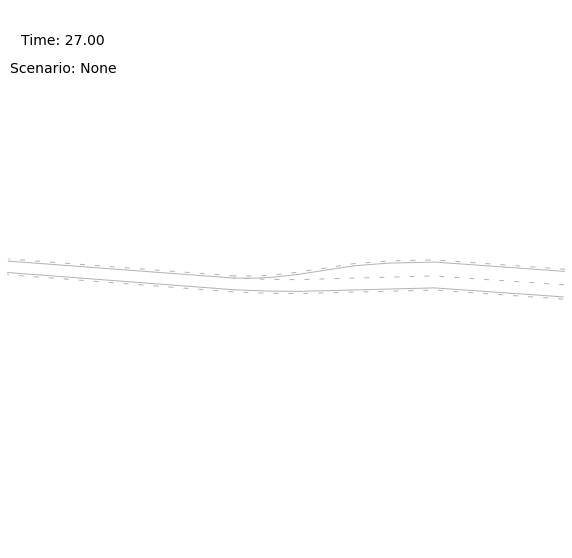

In [2]:
expert_trajectories = generate_expert_trajectories_for_scenario(param_server, sim_time_step=200, renderer="matplotlib_jupyter")

### The generated expert trajectories:
The generated expert trajectories are stored in a dictionary with keys:
* `obs`: list, containing the observation vector for the timestep.
* `act`: list, containing the action that was carried out in that timestep.
* `next_obs`: list, the next observation after carrying out the action `act` in the state `obs`. 

The following 2 cells show some example states and actions for being able to better understanding the format.

In [3]:
# Small number of observations for our agent
print(f'Observations for the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['obs'][:5])

Observations for the agent 66

[array([ 998.184021  , 1006.93701172,    3.08599997,    2.19539237,
        995.9619751 , 1004.27398682,    3.05999994,    1.66448367,
       1004.67498779, 1006.34100342,    3.06100011,    1.7957828 ,
       1004.05700684, 1003.58398438,    3.07299995,    1.92759383]),
 array([ 997.74597168, 1006.9619751 ,    3.08599997,    2.18845916,
        995.63201904, 1004.30102539,    3.05999994,    1.62844038,
       1004.31799316, 1006.36901855,    3.06200004,    1.77660406,
       1003.67797852, 1003.60699463,    3.07500005,    1.82607996]),
 array([ 997.30999756, 1006.98699951,    3.08500004,    2.17947364,
        995.309021  , 1004.32800293,    3.05900002,    1.59439075,
       1003.96502686, 1006.39697266,    3.06200004,    1.75758469,
       1003.31799316, 1003.62902832,    3.07599998,    1.72271013]),
 array([ 996.875     , 1007.01202393,    3.08500004,    2.16549611,
        994.99298096, 1004.35498047,    3.05900002,    1.56133819,
       1003.61499023,

In [4]:
# Small number of actions for our agent
print(f'Actions of the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['act'][:5])

Actions of the agent 66

[[-0.034666060884802626, 0.0],
 [-0.044927593029058605, -0.006168197873944377],
 [-0.06988764225766911, 0.0],
 [-0.09983778594957507, -0.006233605047211027],
 [-0.1200890254762112, 0.0]]


## GAIL implementation

### TF2RL implementation
We have chosen an off the shelf implementation, the library [TF2RL](https://github.com/keiohta/tf2rl). It implements several reinforcement algorithms and training methods in [tensorflow 2](https://www.tensorflow.org/guide/effective_tf2). 

The GAIL agent is built up as follows:
* __Generator:__ A complete DDPG agent with the actor and critic networks. Both of them has 2-2 hidden layers.
* __Discriminator:__ A normal discriminator network with 2 hidden layers.

In this respect the agent is not in the traditional GAIL setup with 2 neural networks, but instead it actually has 5 networks, since the DDPG agent it self has got 4 of them for greater stability during training. The DDPG agent's critic network basically receives the judgement of the Discriminator network as the reward from the environment and its training aims to maximize this reward.

### Integration into BARK
The integration of the TF2RL based GAIL agent is done along existing BARK concepts and has been done in the following most important classes:
* __TF2RLWrapper:__ Wraps the BARK runtime to match the expectations of tf2rl about the environment. The observation and action normalization also takes place here.
    * source: `bark_ml/library_wrappers/lib_tf2rl/tf2rl_wrapper.py`
* __BehaviorTF2RLAgent:__ Base class for TF2RL based agents.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/tf2rl_agent.py`
* __BehaviorGAILAgent:__ The TF2RL based GAIL agent.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/gail_agent.py`
* __TF2RLRunner:__ Base class for TF2RL based runners.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/tf2rl_runner.py`
* __GAILRunner:__ The TF2RL based GAIL runner.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/gail_runner.py`
    
In the followings the training process is shown. Later the performance of a pre-trained agent can be visualized.

---

### Training
The parameters which can be set on demand:
* The number of steps to train for.
* The frequency of testing during training
* The number of episodes in each testing round.

In [5]:
# Costumise some parameters here!!! #

max_steps = 100000          # Number of steps to train for.
test_interval = 100        # test in every ... steps.
test_episodes = 5           # number of test episodes.
gpu = 0                     # use -1 for cpu only.

In [6]:
# IMPORTS
import os
from pathlib import Path

# BARK imports
from bark_project.bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint, GailMergingBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf2rl.tf2rl_wrapper import TF2RLWrapper
from bark_ml.library_wrappers.lib_tf2rl.agents.gail_agent import BehaviorGAILAgent
from bark_ml.library_wrappers.lib_tf2rl.runners.gail_runner import GAILRunner
from bark_ml.library_wrappers.lib_tf2rl.load_expert_trajectories import load_expert_trajectories


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


The next cell deletes the previous logs and launches tensorboard. After tensorboard has launced, please go on to the next cell and start the training. The tensorboard window refreshes it self in every 30 secs, but you can also refresh it by hand in the top right corner.

In [7]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# launching tensorboard and deleting the previous runs logdirs:
!kill 119065
%rm -r "data/logs"
%mkdir "data/logs"
%tensorboard --logdir "data/logs"

zsh:kill:1: kill 119065 failed: no such process
rm: cannot remove 'data/logs': No such file or directory


/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/commons/xodr_parser.py:108: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if lane.find("userData"):
10:00:38.272 [INFO] (trainer.py:65) Restored None
10:00:38.345 [INFO] (irl_trainer.py:73) Total Epi:     1 Steps:       3 Episode Steps:     3 Return: -1.0000 FPS: 47.01
10:00:40.219 [INFO] (irl_trainer.py:73) Total Epi:     2 Steps:      10 Episode Steps:     7 Return: -1.0000 FPS: 503.86
10:00:40.227 [INFO] (irl_trainer.py:73) Total Epi:     3 Steps:      13 Episode Steps:     3 Return: -1.0000 FPS: 430.08
10:00:40.265 [INFO] (irl_trainer.py:73) Total Epi:     4 Steps:      37 Episode Steps:    24 Return: -1.0000 FPS: 672.12
10:00:40.338 [INFO] (irl_trainer.py:73) Total Epi:     5 Steps:      98 Episode Steps:    61 Return:  0

10:00:41.238 [INFO] (irl_trainer.py:73) Total Epi:    66 Steps:     595 Episode Steps:     4 Return: -1.0000 FPS: 464.70
10:00:41.259 [INFO] (irl_trainer.py:73) Total Epi:    67 Steps:     612 Episode Steps:    17 Return: -1.0000 FPS: 850.46
10:00:41.267 [INFO] (irl_trainer.py:73) Total Epi:    68 Steps:     616 Episode Steps:     4 Return: -1.0000 FPS: 621.44
10:00:41.275 [INFO] (irl_trainer.py:73) Total Epi:    69 Steps:     618 Episode Steps:     2 Return: -1.0000 FPS: 373.47
10:00:41.290 [INFO] (irl_trainer.py:73) Total Epi:    70 Steps:     626 Episode Steps:     8 Return: -1.0000 FPS: 637.75
10:00:41.311 [INFO] (irl_trainer.py:73) Total Epi:    71 Steps:     637 Episode Steps:    11 Return: -1.0000 FPS: 559.90
10:00:41.321 [INFO] (irl_trainer.py:73) Total Epi:    72 Steps:     640 Episode Steps:     3 Return: -1.0000 FPS: 370.72
10:00:41.329 [INFO] (irl_trainer.py:73) Total Epi:    73 Steps:     643 Episode Steps:     3 Return: -1.0000 FPS: 480.74
10:00:41.348 [INFO] (irl_trainer

10:00:45.669 [INFO] (irl_trainer.py:73) Total Epi:   134 Steps:    1075 Episode Steps:     2 Return: -1.0000 FPS: 67.93
10:00:45.699 [INFO] (irl_trainer.py:73) Total Epi:   135 Steps:    1077 Episode Steps:     2 Return: -1.0000 FPS: 68.51
10:00:45.732 [INFO] (irl_trainer.py:73) Total Epi:   136 Steps:    1079 Episode Steps:     2 Return: -1.0000 FPS: 64.12
10:00:45.806 [INFO] (irl_trainer.py:73) Total Epi:   137 Steps:    1084 Episode Steps:     5 Return: -1.0000 FPS: 68.96
10:00:45.836 [INFO] (irl_trainer.py:73) Total Epi:   138 Steps:    1086 Episode Steps:     2 Return: -1.0000 FPS: 68.51
10:00:45.885 [INFO] (irl_trainer.py:73) Total Epi:   139 Steps:    1089 Episode Steps:     3 Return: -1.0000 FPS: 63.67
10:00:45.919 [INFO] (irl_trainer.py:73) Total Epi:   140 Steps:    1091 Episode Steps:     2 Return: -1.0000 FPS: 62.28
10:00:45.960 [INFO] (irl_trainer.py:73) Total Epi:   141 Steps:    1094 Episode Steps:     3 Return: -1.0000 FPS: 74.20
10:00:46.018 [INFO] (irl_trainer.py:73) 

10:00:57.408 [INFO] (irl_trainer.py:73) Total Epi:   201 Steps:    1940 Episode Steps:     2 Return: -1.0000 FPS:  6.74
10:00:57.479 [INFO] (irl_trainer.py:73) Total Epi:   202 Steps:    1945 Episode Steps:     5 Return: -1.0000 FPS: 72.01
10:00:57.560 [INFO] (irl_trainer.py:73) Total Epi:   203 Steps:    1951 Episode Steps:     6 Return: -1.0000 FPS: 75.52
10:00:57.783 [INFO] (irl_trainer.py:73) Total Epi:   204 Steps:    1969 Episode Steps:    18 Return: -1.0000 FPS: 80.94
10:00:57.909 [INFO] (irl_trainer.py:73) Total Epi:   205 Steps:    1979 Episode Steps:    10 Return: -1.0000 FPS: 80.19
10:00:58.088 [INFO] (irl_trainer.py:73) Total Epi:   206 Steps:    1993 Episode Steps:    14 Return: -1.0000 FPS: 78.86
10:00:58.308 [INFO] (irl_trainer.py:73) Total Epi:   207 Steps:    2009 Episode Steps:    16 Return: -1.0000 FPS: 73.32
10:00:58.502 [INFO] (irl_trainer.py:73) Total Epi:   208 Steps:    2025 Episode Steps:    16 Return: -1.0000 FPS: 83.18
10:00:58.661 [INFO] (irl_trainer.py:73) 

10:01:10.067 [INFO] (irl_trainer.py:73) Total Epi:   270 Steps:    2825 Episode Steps:    10 Return: -1.0000 FPS: 70.75
10:01:10.221 [INFO] (irl_trainer.py:73) Total Epi:   271 Steps:    2836 Episode Steps:    11 Return: -1.0000 FPS: 72.18
10:01:10.402 [INFO] (irl_trainer.py:73) Total Epi:   272 Steps:    2848 Episode Steps:    12 Return: -1.0000 FPS: 67.26
10:01:10.600 [INFO] (irl_trainer.py:73) Total Epi:   273 Steps:    2863 Episode Steps:    15 Return: -1.0000 FPS: 76.19
10:01:10.760 [INFO] (irl_trainer.py:73) Total Epi:   274 Steps:    2874 Episode Steps:    11 Return: -1.0000 FPS: 69.65
10:01:10.933 [INFO] (irl_trainer.py:73) Total Epi:   275 Steps:    2885 Episode Steps:    11 Return: -1.0000 FPS: 63.93
10:01:11.026 [INFO] (irl_trainer.py:73) Total Epi:   276 Steps:    2891 Episode Steps:     6 Return: -1.0000 FPS: 65.56
10:01:11.210 [INFO] (irl_trainer.py:73) Total Epi:   277 Steps:    2902 Episode Steps:    11 Return: -1.0000 FPS: 60.42
10:01:11.391 [INFO] (irl_trainer.py:73) 

10:01:21.328 [INFO] (irl_trainer.py:73) Total Epi:   338 Steps:    3609 Episode Steps:    14 Return: -1.0000 FPS: 70.91
10:01:21.529 [INFO] (irl_trainer.py:73) Total Epi:   339 Steps:    3626 Episode Steps:    17 Return: -1.0000 FPS: 85.03
10:01:21.662 [INFO] (irl_trainer.py:73) Total Epi:   340 Steps:    3636 Episode Steps:    10 Return: -1.0000 FPS: 76.43
10:01:21.829 [INFO] (irl_trainer.py:73) Total Epi:   341 Steps:    3649 Episode Steps:    13 Return: -1.0000 FPS: 78.23
10:01:22.034 [INFO] (irl_trainer.py:73) Total Epi:   342 Steps:    3665 Episode Steps:    16 Return: -1.0000 FPS: 78.69
10:01:22.200 [INFO] (irl_trainer.py:73) Total Epi:   343 Steps:    3678 Episode Steps:    13 Return: -1.0000 FPS: 79.24
10:01:22.319 [INFO] (irl_trainer.py:73) Total Epi:   344 Steps:    3687 Episode Steps:     9 Return: -1.0000 FPS: 76.78
10:01:22.466 [INFO] (irl_trainer.py:73) Total Epi:   345 Steps:    3699 Episode Steps:    12 Return: -1.0000 FPS: 82.23
10:01:22.628 [INFO] (irl_trainer.py:73) 

10:01:32.159 [INFO] (irl_trainer.py:73) Total Epi:   406 Steps:    4399 Episode Steps:    12 Return: -1.0000 FPS: 71.07
10:01:32.397 [INFO] (irl_trainer.py:73) Total Epi:   407 Steps:    4416 Episode Steps:    17 Return: -1.0000 FPS: 72.00
10:01:32.510 [INFO] (irl_trainer.py:73) Total Epi:   408 Steps:    4424 Episode Steps:     8 Return: -1.0000 FPS: 72.20
10:01:32.679 [INFO] (irl_trainer.py:73) Total Epi:   409 Steps:    4437 Episode Steps:    13 Return: -1.0000 FPS: 77.73
10:01:32.778 [INFO] (irl_trainer.py:73) Total Epi:   410 Steps:    4444 Episode Steps:     7 Return: -1.0000 FPS: 71.59
10:01:32.924 [INFO] (irl_trainer.py:73) Total Epi:   411 Steps:    4455 Episode Steps:    11 Return:  1.0000 FPS: 76.43
10:01:33.126 [INFO] (irl_trainer.py:73) Total Epi:   412 Steps:    4471 Episode Steps:    16 Return: -1.0000 FPS: 79.50
10:01:33.208 [INFO] (irl_trainer.py:73) Total Epi:   413 Steps:    4477 Episode Steps:     6 Return: -1.0000 FPS: 75.40
10:01:33.435 [INFO] (irl_trainer.py:73) 

10:01:46.804 [INFO] (irl_trainer.py:73) Total Epi:   475 Steps:    5466 Episode Steps:    19 Return: -1.0000 FPS: 80.55
10:01:46.943 [INFO] (irl_trainer.py:73) Total Epi:   476 Steps:    5477 Episode Steps:    11 Return:  1.0000 FPS: 79.83
10:01:47.178 [INFO] (irl_trainer.py:73) Total Epi:   477 Steps:    5495 Episode Steps:    18 Return: -1.0000 FPS: 77.10
10:01:47.277 [INFO] (irl_trainer.py:73) Total Epi:   478 Steps:    5501 Episode Steps:     6 Return: -1.0000 FPS: 61.61
10:01:47.413 [INFO] (irl_trainer.py:73) Total Epi:   479 Steps:    5511 Episode Steps:    10 Return: -1.0000 FPS: 74.11
10:01:47.516 [INFO] (irl_trainer.py:73) Total Epi:   480 Steps:    5518 Episode Steps:     7 Return: -1.0000 FPS: 68.94
10:01:47.837 [INFO] (irl_trainer.py:73) Total Epi:   481 Steps:    5541 Episode Steps:    23 Return: -1.0000 FPS: 71.99
10:01:48.086 [INFO] (irl_trainer.py:73) Total Epi:   482 Steps:    5559 Episode Steps:    18 Return: -1.0000 FPS: 72.73
10:01:48.412 [INFO] (irl_trainer.py:73) 

10:02:00.279 [INFO] (irl_trainer.py:73) Total Epi:   543 Steps:    6499 Episode Steps:     7 Return: -1.0000 FPS: 81.34
10:02:00.349 [INFO] (irl_trainer.py:73) Total Epi:   544 Steps:    6503 Episode Steps:     4 Return: -1.0000 FPS: 57.48
10:02:00.459 [INFO] (irl_trainer.py:73) Total Epi:   545 Steps:    6511 Episode Steps:     8 Return: -1.0000 FPS: 74.10
10:02:00.537 [INFO] (irl_trainer.py:73) Total Epi:   546 Steps:    6517 Episode Steps:     6 Return: -1.0000 FPS: 78.23
10:02:00.625 [INFO] (irl_trainer.py:73) Total Epi:   547 Steps:    6524 Episode Steps:     7 Return: -1.0000 FPS: 80.62
10:02:00.690 [INFO] (irl_trainer.py:73) Total Epi:   548 Steps:    6529 Episode Steps:     5 Return: -1.0000 FPS: 78.96
10:02:00.931 [INFO] (irl_trainer.py:73) Total Epi:   549 Steps:    6549 Episode Steps:    20 Return:  1.0000 FPS: 83.34
10:02:01.147 [INFO] (irl_trainer.py:73) Total Epi:   550 Steps:    6567 Episode Steps:    18 Return:  1.0000 FPS: 84.11
10:02:01.344 [INFO] (irl_trainer.py:73) 

10:02:12.441 [INFO] (irl_trainer.py:73) Total Epi:   611 Steps:    7412 Episode Steps:     5 Return: -1.0000 FPS: 78.12
10:02:12.635 [INFO] (irl_trainer.py:73) Total Epi:   612 Steps:    7428 Episode Steps:    16 Return: -1.0000 FPS: 82.86
10:02:12.911 [INFO] (irl_trainer.py:73) Total Epi:   613 Steps:    7451 Episode Steps:    23 Return:  1.0000 FPS: 83.75
10:02:13.094 [INFO] (irl_trainer.py:73) Total Epi:   614 Steps:    7466 Episode Steps:    15 Return: -1.0000 FPS: 82.95
10:02:13.393 [INFO] (irl_trainer.py:73) Total Epi:   615 Steps:    7491 Episode Steps:    25 Return:  1.0000 FPS: 83.83
10:02:13.506 [INFO] (irl_trainer.py:73) Total Epi:   616 Steps:    7499 Episode Steps:     8 Return: -1.0000 FPS: 71.88
10:02:13.630 [INFO] (irl_trainer.py:73) Total Epi:   617 Steps:    7507 Episode Steps:     8 Return: -1.0000 FPS: 65.03
10:02:13.772 [INFO] (irl_trainer.py:73) Total Epi:   618 Steps:    7518 Episode Steps:    11 Return: -1.0000 FPS: 78.76
10:02:13.958 [INFO] (irl_trainer.py:73) 

10:02:25.506 [INFO] (irl_trainer.py:73) Total Epi:   680 Steps:    8366 Episode Steps:    15 Return: -1.0000 FPS: 68.12
10:02:25.630 [INFO] (irl_trainer.py:73) Total Epi:   681 Steps:    8375 Episode Steps:     9 Return: -1.0000 FPS: 73.37
10:02:25.712 [INFO] (irl_trainer.py:73) Total Epi:   682 Steps:    8381 Episode Steps:     6 Return: -1.0000 FPS: 74.31
10:02:25.784 [INFO] (irl_trainer.py:73) Total Epi:   683 Steps:    8386 Episode Steps:     5 Return: -1.0000 FPS: 71.72
10:02:26.045 [INFO] (irl_trainer.py:73) Total Epi:   684 Steps:    8405 Episode Steps:    19 Return: -1.0000 FPS: 73.22
10:02:26.294 [INFO] (irl_trainer.py:73) Total Epi:   685 Steps:    8421 Episode Steps:    16 Return: -1.0000 FPS: 64.73
10:02:26.369 [INFO] (irl_trainer.py:73) Total Epi:   686 Steps:    8426 Episode Steps:     5 Return: -1.0000 FPS: 67.63
10:02:26.601 [INFO] (irl_trainer.py:73) Total Epi:   687 Steps:    8444 Episode Steps:    18 Return:  1.0000 FPS: 78.14
10:02:26.885 [INFO] (irl_trainer.py:73) 

10:02:37.958 [INFO] (irl_trainer.py:73) Total Epi:   748 Steps:    9237 Episode Steps:     6 Return: -1.0000 FPS: 78.27
10:02:38.095 [INFO] (irl_trainer.py:73) Total Epi:   749 Steps:    9247 Episode Steps:    10 Return:  1.0000 FPS: 73.62
10:02:38.242 [INFO] (irl_trainer.py:73) Total Epi:   750 Steps:    9258 Episode Steps:    11 Return:  1.0000 FPS: 76.12
10:02:38.570 [INFO] (irl_trainer.py:73) Total Epi:   751 Steps:    9280 Episode Steps:    22 Return:  1.0000 FPS: 67.27
10:02:38.756 [INFO] (irl_trainer.py:73) Total Epi:   752 Steps:    9293 Episode Steps:    13 Return:  1.0000 FPS: 70.37
10:02:39.037 [INFO] (irl_trainer.py:73) Total Epi:   753 Steps:    9311 Episode Steps:    18 Return:  1.0000 FPS: 64.43
10:02:39.119 [INFO] (irl_trainer.py:73) Total Epi:   754 Steps:    9316 Episode Steps:     5 Return: -1.0000 FPS: 63.06
10:02:39.319 [INFO] (irl_trainer.py:73) Total Epi:   755 Steps:    9330 Episode Steps:    14 Return: -1.0000 FPS: 70.55
10:02:39.640 [INFO] (irl_trainer.py:73) 

KeyboardInterrupt: 

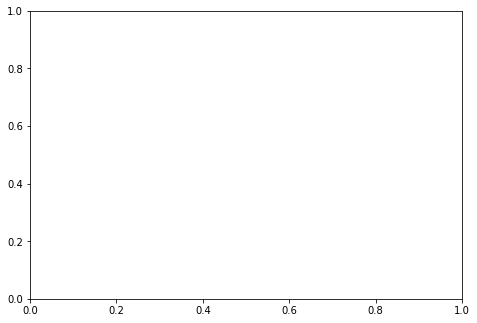

In [8]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
params["ML"]["GAILRunner"]["tf2rl"]["max_steps"] = max_steps
params["ML"]["GAILRunner"]["tf2rl"]["test_interval"] = test_interval
params["ML"]["GAILRunner"]["tf2rl"]["test_episodes"] = test_episodes
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                                number_of_senarios=500,
                                random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                         render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
                           normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                               params=params)

# load the expert trajectories
expert_trajectories, _, _ = load_expert_trajectories(
    params['ML']['ExpertTrajectories']['expert_path_dir'],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env, # the unwrapped env has to be used, since that contains the unnormalized spaces.
    subset_size=params["ML"]["ExpertTrajectories"]["subset_size"]
    ) 

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# train the agent
runner.Train()

### Trained agent visualization:
Please set up the number of scenarios to visualize in the next cell!

In [9]:
# Number of scenarios to visualize:
num_scenarios_to_visualize = 10

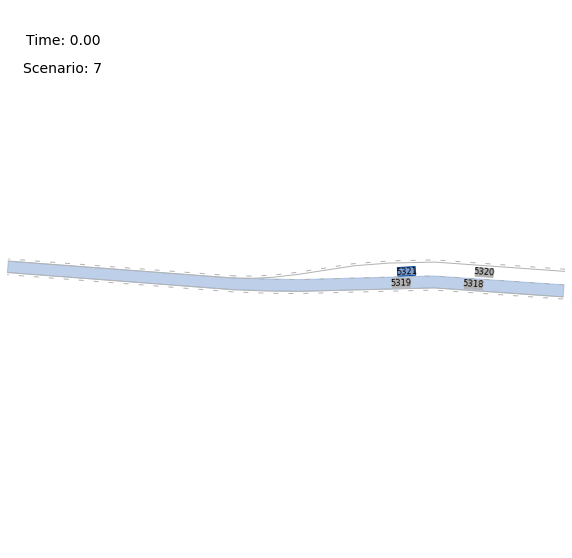

In [ ]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# setting the path for the pretrained agent.
params["ML"]["GAILRunner"]["tf2rl"]["model_dir"] = "../../../com_github_gail_4_bark_large_data_store/pretrained_agents/gail/merging"

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
params["ML"]["GAILRunner"]["tf2rl"]["max_steps"] = max_steps
params["ML"]["GAILRunner"]["tf2rl"]["test_interval"] = test_interval
params["ML"]["GAILRunner"]["tf2rl"]["test_episodes"] = test_episodes
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,)

# Visualize the agent
runner.Visualize(num_scenarios_to_visualize, renderer="matplotlib_jupyter")